<div align='center'>
<h1 style='font-size:38px;'>Grain Temperature Calculation</h1>
<h2 style='font-weight:400;'>Using <code>GrainStar</code> to derive equilibrium temperatures</h2>
<p><em>Thermal distance grid → temperature vs distance & size</em></p>
</div>

---
**Contents:**
1. Initialize grain and star
2. Load thermal distance grid
3. Examine temperature range
4. Interpolate temperatures
5. Plot profiles for selected sizes
6. Contour map size vs distance

## 1. Imports and object setup

In [1]:
from pyGrater import stargrains as stgr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Create grain (loads Q tables) and star (loads spectrum + properties)
grain = stgr.Grain(redo_Q=False)
star = stgr.Star('bPic')

# Initialize GrainStar (loads or computes thermal distance grid)
stargrain = stgr.GrainStar(grain, star, N_temp=300, redo_therm_dist=False)

General parameters file: /Users/prioletp/PhD/public_codes/pyGrater/pyGrater/parameters/general.yaml
Loading aC_ACAR grain properties...
aC_ACAR optical tables already exist :
--> Wavelenghts : 2000 values from 5.0e-02 to 1.5e+03 microns
--> Sizes : 2000 values from 1.0e-02 to 5.0e+03 microns
Star properties file: /Users/prioletp/PhD/public_codes/pyGrater/pyGrater/star_data/stars_main_properties.txt
Index for star 'bPic': 3
Star properties dictionary:
{ 'B0': np.str_('nan'),
  'apmag': np.str_('3.86'),
  'band': np.str_('V'),
  'dist': np.str_('19.440'),
  'logg': np.str_('4.2'),
  'mass': np.str_('1.75'),
  'mdot': np.str_('1.1'),
  'per': np.str_('nan'),
  'r0': np.str_('nan'),
  'rad': np.str_('1.759'),
  'spt': np.str_('A6'),
  'star': np.str_('bPic'),
  'tcoro': np.str_('1.1e6'),
  'temp': np.str_('8200'),
  'tilt': np.str_('nan'),
  'vsini': np.str_('122'),
  'vw': np.str_('nan')}
Loaded star 'bPic' properties:
{ 'B0': np.str_('nan'),
  'apmag': np.str_('3.86'),
  'band': np.str_(

## 2. Thermal equilibrium distance
To calculate the temperature of dust grains, we first calculate the thermal equilibrium distance, $r(a,T_{\mathrm{d}})$, for a range of grain sizes and temperatures (i.e the distance at which a grain of certain size and temperature would be at thermal equilibrium).

It is calculated in the following way:
\begin{equation}
r(a,T_{\mathrm{d}})=\frac{d_{\star}}{2}\sqrt{\frac{\int_{\lambda}Q_{\mathrm{abs}}F_{\star}(\lambda)\mathrm{d}\lambda}{\int_{\lambda}Q_{\mathrm{abs}}\pi B_{\lambda}\left(T_{\mathrm{d}}\right)\mathrm{d}\lambda}}
\end{equation}
where F⋆(λ) is the stellar flux at Earth. 

In [3]:
therm_dist = stargrain.therm_dist          # shape: (n_sizes, n_T)
temp_range = stargrain.temp_range         # temperatures (K)
sizes = grain.Qabs_sizes                  # micron
print('Thermal grid shape:', therm_dist.shape)
print('Temperature range: {:.1f} – {:.1f} K'.format(temp_range.min(), temp_range.max()))
print('Size range: {:.3e} – {:.3e} µm'.format(sizes.min(), sizes.max()))

Thermal grid shape: (2000, 300)
Temperature range: 3.0 – 2000.0 K
Size range: 1.000e-02 – 5.000e+03 µm


## 4. Interpolate temperatures at chosen distances

The r(a,Td) function is then numerically reversed to get Td(a,r). This is done using the `stargrain.get_temperature(distances)` to get equilibrium temperatures for all sizes at specified distances.

Source: Lebreton et al. 2013

In [4]:
distances = np.linspace(0.01, 10, 2000) #A range of r for the calculation of Td

temperatures = stargrain.get_temperature(distances)

print('Temperatures shape:', temperatures.shape)
print('Min/Max T:', temperatures.min(), temperatures.max())

(2000, 300) (300,)
3.0 2000.0
0.01 10.0
Temperatures shape: (2000, 2000)
Min/Max T: 137.7876130730313 2003.0


## 3. Visualize raw thermal distance grid
Rows: sizes; Columns: temperatures.

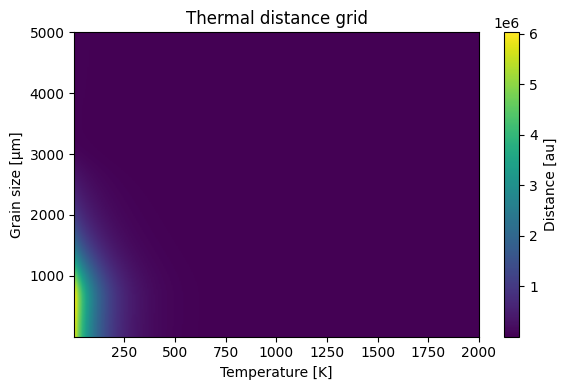

In [5]:
plt.figure(figsize=(6,4))
plt.imshow(therm_dist, aspect='auto', origin='lower',
           extent=[temp_range.min(), temp_range.max(), sizes.min(), sizes.max()])
plt.colorbar(label='Distance [au]')
plt.xlabel('Temperature [K]')
plt.ylabel('Grain size [µm]')
plt.title('Thermal distance grid')
plt.tight_layout()

## 5. Plot temperature vs distance for selected sizes

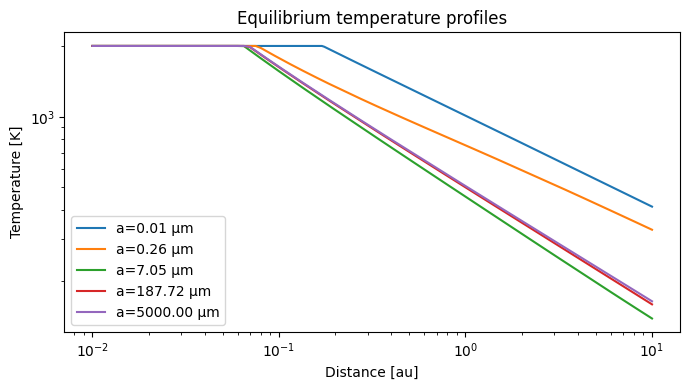

In [10]:
idx_sample = np.linspace(0, len(sizes)-1, 5, dtype=int)
plt.figure(figsize=(7,4))
for i in idx_sample:
    plt.loglog(distances, temperatures[i], label=f'a={sizes[i]:.2f} µm')
plt.xlabel('Distance [au]')
plt.ylabel('Temperature [K]')
plt.title('Equilibrium temperature profiles')
plt.legend()
plt.tight_layout()

## 6. Contour plot (size vs distance)
Log-size vs distance colored by temperature.

Be careful: To plot this you must have previously calculated the `stargrain.get_temperature` method

Plotting temperatures for sizes between 0.01 and 4999.999999999999 between distances 0.01 and 0.5


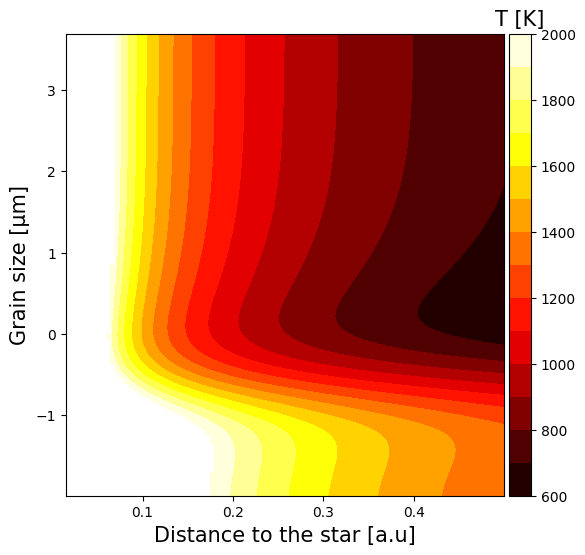

In [6]:
stargrain.plot_temperatures(min_size=None, max_size=None, min_dist=None, max_dist=0.5)

## 7. Notes
- Grid resolution controlled by `N_temp` in `GrainStar`.
- Sublimation temperature (`Tsub`) limits high-T region.
- Thermal distance grid cached on disk (NPZ) for reuse.
- Modify grain optical properties (sizes / wavelengths) via `general.yaml` then recompute.